# Building regression models for arr_delay
Identifying the most suitable model out of different modeling approaches including, linear regression, random forest regression, boosted tree regression & support verctor regression. For each model approach different hyperparameters will be analysed supported by k-fold cross-validation.

In [264]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# from pprint import pprint


In [265]:
# Adjust settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline

In [266]:
# Load preprocessed dataset
data_path = '../data/processed/'
df = pd.read_pickle(os.path.join(data_path, 'final_one_hot.pkl'))

In [273]:
# Generate train/test splits
X_train_arr, X_test_arr, y_train_arr, y_test_arr = train_test_split(df.drop(['arr_delay'], axis=1), df['arr_delay'], test_size=0.33, random_state=42)

# Create dataframe to save model evaluation parameters
eval = pd.DataFrame(columns= ['Group', 'Model', 'R^2 test', 'RMSE test', 'R^2 train', 'RMSE train'])

## 1) Linear regression model

In [274]:
# Create a linear regression model for arr and dep delay
lr_arr = LinearRegression(fit_intercept=True)

# Fit models to training data
lr_arr.fit(X_train_arr, y_train_arr)

# Predict values for train and test data
lr_pred_arr_train = lr_arr.predict(X_train_arr)

lr_pred_arr_test = lr_arr.predict(X_test_arr)

# Save r^2 and RMSE for model in dataframe for later comparison
eval = eval.append({
    'Group': 'arr',
    'Model': 'Linear',
    'R^2 test': r2_score(y_test_arr, lr_pred_arr_test),
    'RMSE test': mean_squared_error(y_test_arr, lr_pred_arr_test, squared=False),
    'R^2 train': r2_score(y_train_arr, lr_pred_arr_train),
    'RMSE train': mean_squared_error(y_train_arr, lr_pred_arr_train, squared=False)
    }, ignore_index=True)

eval.round(decimals=3)

,Group,Model,R^2 test,RMSE test,R^2 train,RMSE train
0,arr,Linear,-1177444904240.407,22258149.525,0.907,6.335


## 2) Ridge regression

In [275]:
# Range of regularization parameter alpha
alpha = [2, 3, 4] #[1, 5, 10, 20], [4, 5, 6], [2, 3, 4]

# Create random grid
param_grid = {'alpha': alpha}

# Create a ridge regression model for delay
rid_arr = Ridge(fit_intercept=True)

# Initiate the grid search models
grid_arr = GridSearchCV(estimator=rid_arr, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

# Fit the grid search models
grid_arr.fit(X_train_arr, y_train_arr)

# Print best parameters for the models
print(grid_arr.best_params_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
{'alpha': 3}


In [276]:
# Create ridge regression models with best alpha values
rid_arr = Ridge(alpha=3, fit_intercept=True)

# Fit models to training data
rid_arr.fit(X_train_arr, y_train_arr)

# Predict values for train and test data
rid_pred_arr_train = rid_arr.predict(X_train_arr)

rid_pred_arr_test = rid_arr.predict(X_test_arr)

# Save r^2 and RMSE for model in dataframe for later comparison
eval = eval.append({
    'Group': 'arr',
    'Model': 'Ridge',
    'R^2 test': r2_score(y_test_arr, rid_pred_arr_test),
    'RMSE test': mean_squared_error(y_test_arr, rid_pred_arr_test, squared=False),
    'R^2 train': r2_score(y_train_arr, rid_pred_arr_train),
    'RMSE train': mean_squared_error(y_train_arr, rid_pred_arr_train, squared=False)
    }, ignore_index=True)

eval.round(decimals=3)

,Group,Model,R^2 test,RMSE test,R^2 train,RMSE train
0,arr,Linear,-1177444904240.407,22258149.525,0.907,6.335
1,arr,Ridge,0.903,6.387,0.905,6.398


In [277]:
fi = pd.DataFrame({'Feature': rid_arr.feature_names_in_, 'Weight': rid_arr.coef_}, columns=['Feature', 'Weight'])
stdevs = []
for i in X_train_arr.columns:
    stdev = X_train_arr[i].std()
    stdevs.append(stdev)
fi['Std'] = np.array(stdevs).reshape(-1, 1)
fi['Importance'] = fi['Weight'] * fi['Std'] / 100
fi = fi.reindex(fi.Importance.abs().sort_values(ascending=False).index)
fi[['Feature', 'Importance']].head(10)

,Feature,Importance
0,dep_delay,0.191
9,hour_of_day_arr,-0.061
12,mod_sched_arr,0.039
8,hour_of_day_dep,0.028
86,AC_type_DH4,0.019
171,routing_East Carmen_North Gregory,0.012
87,AC_type_DHX,0.009
121,routing_East Carmen_East Holly,0.008
209,routing_East Carmen_Youngland,0.007
249,routing_Lake Lawrencechester_Lake Richardberg,0.007


## 3) Lasso Regression

In [278]:
# Range of regularization parameter alpha
alpha = [0, 0.3, 0.7] #[0, 1, 10, 100, 1000]

# Create random grid
param_grid = {'alpha': alpha}

# Create a lasso regression model for arr delay
las_arr = Lasso(fit_intercept=True)

# Initiate the grid search models
grid_arr = GridSearchCV(estimator=las_arr, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

# Fit the grid search models
grid_arr.fit(X_train_arr, y_train_arr)

# Print best parameters for the models
print(grid_arr.best_params_)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
{'alpha': 0}


In [279]:
# Create lasso regression models with best alpha values
las_arr = Lasso(alpha=0, fit_intercept=True)

# Fit models to training data
las_arr.fit(X_train_arr, y_train_arr)

# Predict values for train and test data
las_pred_arr_train = las_arr.predict(X_train_arr)

las_pred_arr_test = las_arr.predict(X_test_arr)

# Save r^2 and RMSE for both models in dataframe for later comparison
eval = eval.append({
    'Group': 'arr',
    'Model': 'Lasso',
    'R^2 test': r2_score(y_test_arr, las_pred_arr_test),
    'RMSE test': mean_squared_error(y_test_arr, las_pred_arr_test, squared=False),
    'R^2 train': r2_score(y_train_arr, las_pred_arr_train),
    'RMSE train': mean_squared_error(y_train_arr, las_pred_arr_train, squared=False)
    }, ignore_index=True)

eval.round(decimals=3)

,Group,Model,R^2 test,RMSE test,R^2 train,RMSE train
0,arr,Linear,-1177444904240.407,22258149.525,0.907,6.335
1,arr,Ridge,0.903,6.387,0.905,6.398
2,arr,Lasso,0.901,6.453,0.907,6.335


## 4) Huber Regression

In [282]:
# Create the parameter grid

# Range of epsilon
epsilon = [1, 2, 3] #[1, 5, 10], [4, 5, 6], [2, 3, 4]

# Range of alpha
alpha = [0.1, 0.2, 0.3] #[0, 1, 10, 100], [0, 0.3, 0.7], [0.6, 0.7, 0.8], [0.3, 0.4, 0.5]

# Create random grid
param_grid = {
    'epsilon': epsilon,
    'alpha': alpha
    }

# Create a Huber regression model for arr delay
hub_arr = HuberRegressor(fit_intercept=True)

# Initiate the grid search models
grid_arr = GridSearchCV(estimator=hub_arr, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

# Fit the grid search models
grid_arr.fit(X_train_arr, y_train_arr)

# Print best parameters for the models
print(grid_arr.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'alpha': 0.3, 'epsilon': 2}


In [283]:
# Creating Huber regression model with best alpha and apsilon values
hub_arr = HuberRegressor(alpha=0.3, epsilon=2, fit_intercept=True)

# Fit models to training data
hub_arr.fit(X_train_arr, y_train_arr)

# Predict values for train and test data
hub_pred_arr_train = hub_arr.predict(X_train_arr)

hub_pred_arr_test = hub_arr.predict(X_test_arr)

# Save r^2 and RMSE for model in dataframe for later comparison
eval = eval.append({
    'Group': 'arr',
    'Model': 'Huber',
    'R^2 test': round(r2_score(y_test_arr, hub_pred_arr_test), 3),
    'RMSE test': round(mean_squared_error(y_test_arr, hub_pred_arr_test, squared=False), 3),
    'R^2 train': round(r2_score(y_train_arr, hub_pred_arr_train), 3),
    'RMSE train': round(mean_squared_error(y_train_arr, hub_pred_arr_train, squared=False), 3)
    }, ignore_index=True)

eval.round(decimals=3)

,Group,Model,R^2 test,RMSE test,R^2 train,RMSE train
0,arr,Linear,-1177444904240.407,22258149.525,0.907,6.335
1,arr,Ridge,0.903,6.387,0.905,6.398
2,arr,Lasso,0.901,6.453,0.907,6.335
3,arr,Huber,0.882,7.047,0.876,7.328


## 5) ElasticNet

In [287]:
# Create the parameter grid

# Range alpha
alpha = [0] #[0, 1, 2]

# Range of l1_ratio
l1_ratio = [0] #[0, 0.5, 1]

# Range of max_depth
max_iter = [60, 70, 80] #[100, 300, 500], [80, 90, 100]

# Create random grid
param_grid = {
    'alpha': alpha,
    'l1_ratio': l1_ratio,
    'max_iter': max_iter
    }

# Create a Huber regression model for arr delay
en_arr = ElasticNet(random_state=42)

# Initiate the grid search models
grid_arr = GridSearchCV(estimator=en_arr, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

# Fit the grid search models
grid_arr.fit(X_train_arr, y_train_arr)

# Print best parameters for the models
print(grid_arr.best_params_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
{'alpha': 0, 'l1_ratio': 0, 'max_iter': 80}


In [288]:
# Creating ElasticNet regression model with best parameters
en_arr = ElasticNet(alpha=0, l1_ratio=0, max_iter=80, random_state=42)

# Fit models to training data
en_arr.fit(X_train_arr, y_train_arr)

# Predict values for train and test data
en_pred_arr_train = en_arr.predict(X_train_arr)

en_pred_arr_test = en_arr.predict(X_test_arr)

# Save r^2 and RMSE for model in dataframe for later comparison
eval = eval.append({
    'Group': 'arr',
    'Model': 'ElasticNet',
    'R^2 test': round(r2_score(y_test_arr, en_pred_arr_test), 3),
    'RMSE test': round(mean_squared_error(y_test_arr, en_pred_arr_test, squared=False), 3),
    'R^2 train': round(r2_score(y_train_arr, en_pred_arr_train), 3),
    'RMSE train': round(mean_squared_error(y_train_arr, en_pred_arr_train, squared=False), 3)
    }, ignore_index=True)

eval.round(decimals=3)

,Group,Model,R^2 test,RMSE test,R^2 train,RMSE train
0,arr,Linear,-1177444904240.407,22258149.525,0.907,6.335
1,arr,Ridge,0.903,6.387,0.905,6.398
2,arr,Lasso,0.901,6.453,0.907,6.335
3,arr,Huber,0.882,7.047,0.876,7.328
4,arr,ElasticNet,0.901,6.445,0.907,6.341


## 6) Decision Tree Regression

In [290]:
# Create the parameter grid to sample from during fitting

# Maximum number of leafs in tree
max_depth = [17, 18, 19] # [1, 2, 4, 8, 16, 32, 63, 128], [25, 30, 35],[15, 20, 25], [19, 20, 21]
# Minimum impurity decrease
min_impurity_decrease = [0.05, 0.1, 0.15] # [0.1, 0.4, 0.6, 0.9]
# Minimum number of samples required at each leaf node
min_samples_leaf = [16, 17, 18] # [1, 2, 4, 8, 16], [15, 20, 25], [19, 20, 21], [17, 18, 19], [16, 17, 18]

# Create the random grid
random_grid = {
    'max_depth': max_depth,
    'min_impurity_decrease': min_impurity_decrease,
    'min_samples_leaf': min_samples_leaf,
    }

# Create a decision tree regression model for arr delay
dt_arr = DecisionTreeRegressor(random_state=42)

# Initiate the grid search models
dt_arr_random = RandomizedSearchCV(estimator=dt_arr, param_distributions=random_grid, cv=3, n_jobs=-1, verbose=1)

# Fit the grid search models
dt_arr_random.fit(X_train_arr, y_train_arr)

# Print best parameters for the models
print(dt_arr_random.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'min_samples_leaf': 18, 'min_impurity_decrease': 0.1, 'max_depth': 18}


In [291]:
# Creating Decision Tree regression models with best parameters
dt_arr = DecisionTreeRegressor(max_depth=18, min_impurity_decrease=0.1, min_samples_leaf=18, random_state=42)

# Fit models to training data
dt_arr.fit(X_train_arr, y_train_arr)

# Predict values for train and test data
dt_pred_arr_train = dt_arr.predict(X_train_arr)

dt_pred_arr_test = dt_arr.predict(X_test_arr)

# Save r^2 and RMSE for model in dataframe for later comparison
eval = eval.append({
    'Group': 'arr',
    'Model': 'Decision Tree',
    'R^2 test': round(r2_score(y_test_arr, dt_pred_arr_test), 3),
    'RMSE test': round(mean_squared_error(y_test_arr, dt_pred_arr_test, squared=False), 3),
    'R^2 train': round(r2_score(y_train_arr, dt_pred_arr_train), 3),
    'RMSE train': round(mean_squared_error(y_train_arr, dt_pred_arr_train, squared=False), 3)
    }, ignore_index=True)

eval.round(decimals=3)

,Group,Model,R^2 test,RMSE test,R^2 train,RMSE train
0,arr,Linear,-1177444904240.407,22258149.525,0.907,6.335
1,arr,Ridge,0.903,6.387,0.905,6.398
2,arr,Lasso,0.901,6.453,0.907,6.335
3,arr,Huber,0.882,7.047,0.876,7.328
4,arr,ElasticNet,0.901,6.445,0.907,6.341
5,arr,Decision Tree,0.880,7.096,0.883,7.121


## 7) Gradient Boosting

In [292]:
# Create the parameter grid

# Range for learning_rate
learning_rate = [0.1, 0.2, 0.3] #[0, 0.25, 0.5, 0.75, 1]

# Range of n_estimators
n_estimators = [100, 150, 200] #[1, 2, 4, 8, 16, 32, 64, 128]

# Range of max_depth
max_depth = [3, 4, 5] #[1, 2, 3]


# Create random grid
param_grid = {
    'learning_rate': learning_rate,
    'n_estimators': n_estimators,
    'max_depth': max_depth
    }

# Create a Huber regression model for arr delay
gb_arr = GradientBoostingRegressor(random_state=42)

# Initiate the grid search models
grid_arr = GridSearchCV(estimator=gb_arr, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

# Fit the grid search models
grid_arr.fit(X_train_arr, y_train_arr)

# Print best parameters for the models
print(grid_arr.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 150}


In [293]:
# Creating GradientBoosting regression model with best parameters
gb_arr = GradientBoostingRegressor(learning_rate=0.2, max_depth=3, n_estimators=150, random_state=42)

# Fit models to training data
gb_arr.fit(X_train_arr, y_train_arr)

# Predict values for train and test data
gb_pred_arr_train = gb_arr.predict(X_train_arr)

gb_pred_arr_test = gb_arr.predict(X_test_arr)

# Save r^2 and RMSE for model in dataframe for later comparison
eval = eval.append({
    'Group': 'arr',
    'Model': 'GradientBoosting',
    'R^2 test': round(r2_score(y_test_arr, gb_pred_arr_test), 3),
    'RMSE test': round(mean_squared_error(y_test_arr, gb_pred_arr_test, squared=False), 3),
    'R^2 train': round(r2_score(y_train_arr, gb_pred_arr_train), 3),
    'RMSE train': round(mean_squared_error(y_train_arr, gb_pred_arr_train, squared=False), 3)
    }, ignore_index=True)

eval.round(decimals=3)

,Group,Model,R^2 test,RMSE test,R^2 train,RMSE train
0,arr,Linear,-1177444904240.407,22258149.525,0.907,6.335
1,arr,Ridge,0.903,6.387,0.905,6.398
2,arr,Lasso,0.901,6.453,0.907,6.335
3,arr,Huber,0.882,7.047,0.876,7.328
4,arr,ElasticNet,0.901,6.445,0.907,6.341
5,arr,Decision Tree,0.880,7.096,0.883,7.121
6,arr,GradientBoosting,0.902,6.429,0.915,6.047


In [304]:
fi_gb = pd.DataFrame({'Feature': gb_arr.feature_names_in_, 'Importance': gb_arr.feature_importances_}, columns=['Feature', 'Importance'])
fi_gb = fi_gb.reindex(fi_gb.Importance.abs().sort_values(ascending=False).index)
fi_gb.head(10)

,Feature,Importance
0,dep_delay,0.942
1,gnd_mingt,0.009
13,density,0.004
171,routing_East Carmen_North Gregory,0.004
4,ca_count,0.003
12,mod_sched_arr,0.002
209,routing_East Carmen_Youngland,0.002
121,routing_East Carmen_East Holly,0.001
213,routing_East Latashaview_East Carmen,0.001
7,day_of_week,0.001


## 8) Random Forest

In [294]:
# Create the parameter grid to sample from during fitting

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(200, 1000, num=10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of leafs in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
    }

# Create a decision tree regression model for arr delay
rf_arr = RandomForestRegressor(random_state=42)

# Initiate the grid search models
rf_arr_random = RandomizedSearchCV(estimator=rf_arr, param_distributions=random_grid, n_iter=100, cv=3, n_jobs=-1, random_state=42, verbose=1)

# Fit the grid search models
rf_arr_random.fit(X_train_arr, y_train_arr)

# Print best parameters for the models
print(rf_arr_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 377, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}


In [302]:
# Create the parameter grid

# Number of trees in random forest
n_estimators = [650] #[300, 350, 400], [400, 500], [500, 550], [550, 650], [650, 700]
# Maximum number of leafs in tree
max_depth = [35, 36] #[90, 100, 110], [70, 80, 90], [50, 60, 70], [30, 40, 50], [35, 40, 45], [38, 40, 42], [38, 39, 40], [36, 37, 38]
# Minimum number of samples required to split a node
min_samples_split = [23, 28, 33] #[9, 10, 11], [11, 12, 13], [13, 14, 15], [15, 16, 17], [17, 18, 19], [19, 20, 21], [21, 22, 23]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2] #[1, 2, 3]


# Create random grid
param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    }

# Initiate the grid search models
grid_arr = GridSearchCV(estimator=rf_arr, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

# Fit the grid search models
grid_arr.fit(X_train_arr, y_train_arr)

# Print best parameters for the models
print(grid_arr.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'max_depth': 36, 'min_samples_leaf': 2, 'min_samples_split': 28, 'n_estimators': 650}


In [303]:
# Creating GradientBoosting regression model with best parameters
rf_arr = RandomForestRegressor(max_depth=36, min_samples_leaf=2, min_samples_split=28, n_estimators=650, random_state=42)

# Fit models to training data
rf_arr.fit(X_train_arr, y_train_arr)

# Predict values for train and test data
rf_pred_arr_train = rf_arr.predict(X_train_arr)

rf_pred_arr_test = rf_arr.predict(X_test_arr)

# Save r^2 and RMSE for model in dataframe for later comparison
eval = eval.append({
    'Group': 'arr',
    'Model': 'RandomForest',
    'R^2 test': round(r2_score(y_test_arr, rf_pred_arr_test), 3),
    'RMSE test': round(mean_squared_error(y_test_arr, rf_pred_arr_test, squared=False), 3),
    'R^2 train': round(r2_score(y_train_arr, rf_pred_arr_train), 3),
    'RMSE train': round(mean_squared_error(y_train_arr, rf_pred_arr_train, squared=False), 3)
    }, ignore_index=True)

eval.round(decimals=3)

,Group,Model,R^2 test,RMSE test,R^2 train,RMSE train
0,arr,Linear,-1177444904240.407,22258149.525,0.907,6.335
1,arr,Ridge,0.903,6.387,0.905,6.398
2,arr,Lasso,0.901,6.453,0.907,6.335
3,arr,Huber,0.882,7.047,0.876,7.328
4,arr,ElasticNet,0.901,6.445,0.907,6.341
5,arr,Decision Tree,0.880,7.096,0.883,7.121
6,arr,GradientBoosting,0.902,6.429,0.915,6.047
7,arr,RandomForest,0.894,6.683,0.934,5.336


## RMSE over the day

In [305]:
# Evaluation flight of the day

RMSE_rid = []
for i in range(1,10):
    indices = X_test_arr[X_test_arr['flight_of_day']==i].index
    rmse_fod = np.sqrt(
        mean_squared_error(y_test_arr.loc[indices], 
        rid_arr.predict(X_test_arr.loc[indices]))
        )
    n = X_test_arr.loc[indices].shape[0]
    print('RMSE for Landing Delay for flight ', i , ' is ', round(rmse_fod,2), ' minutes, using ', n, ' test observations')
    
    RMSE_rid.append(rmse_fod)

RMSE for Landing Delay for flight  1  is  6.39  minutes, using  569  test observations
RMSE for Landing Delay for flight  2  is  6.18  minutes, using  532  test observations
RMSE for Landing Delay for flight  3  is  6.5  minutes, using  539  test observations
RMSE for Landing Delay for flight  4  is  6.21  minutes, using  433  test observations
RMSE for Landing Delay for flight  5  is  6.76  minutes, using  358  test observations
RMSE for Landing Delay for flight  6  is  6.89  minutes, using  185  test observations
RMSE for Landing Delay for flight  7  is  5.18  minutes, using  89  test observations
RMSE for Landing Delay for flight  8  is  5.38  minutes, using  13  test observations
RMSE for Landing Delay for flight  9  is  3.86  minutes, using  1  test observations


In [307]:
# Evaluation flight of the day

RMSE_gb = []
for i in range(1,10):
    indices = X_test_arr[X_test_arr['flight_of_day']==i].index
    rmse_fod = np.sqrt(
        mean_squared_error(y_test_arr.loc[indices], 
        gb_arr.predict(X_test_arr.loc[indices]))
        )
    n = X_test_arr.loc[indices].shape[0]
    print('RMSE for Landing Delay for flight ', i , ' is ', round(rmse_fod,2), ' minutes, using ', n, ' test observations')
    
    RMSE_gb.append(rmse_fod)

RMSE for Landing Delay for flight  1  is  6.35  minutes, using  569  test observations
RMSE for Landing Delay for flight  2  is  6.38  minutes, using  532  test observations
RMSE for Landing Delay for flight  3  is  6.64  minutes, using  539  test observations
RMSE for Landing Delay for flight  4  is  6.08  minutes, using  433  test observations
RMSE for Landing Delay for flight  5  is  6.8  minutes, using  358  test observations
RMSE for Landing Delay for flight  6  is  6.78  minutes, using  185  test observations
RMSE for Landing Delay for flight  7  is  5.39  minutes, using  89  test observations
RMSE for Landing Delay for flight  8  is  5.28  minutes, using  13  test observations
RMSE for Landing Delay for flight  9  is  4.29  minutes, using  1  test observations


Text(0, 0.5, 'RMSE')

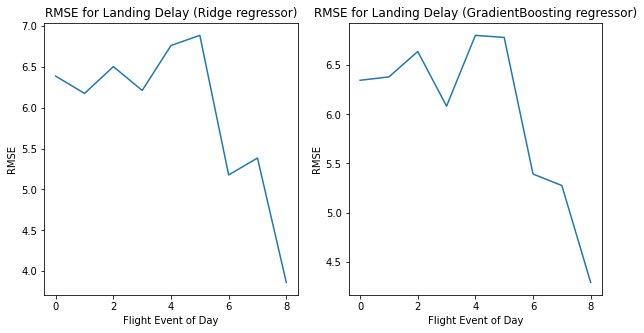

In [309]:
# Plotting the difference of RSMEs over flight events
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(RMSE_rid)
plt.title('RMSE for Landing Delay (Ridge regressor)')
plt.xlabel('Flight Event of Day')
plt.ylabel('RMSE')
plt.subplot(1,2,2)
plt.plot(RMSE_gb)
plt.title('RMSE for Landing Delay (GradientBoosting regressor)')
plt.xlabel('Flight Event of Day')
plt.ylabel('RMSE')